##Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers.core import Dense, Dropout
from keras.layers import GRU
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta, Adamax,Nadam
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from keras.models import Sequential
import timeit
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import Callback, CSVLogger

##Connect Driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup Data

In [ ]:
start = timeit.default_timer()
dataframe = pd.read_csv('/content/drive/MyDrive/Research/Deep Learning/LaminatedPlate_RZT_Q9.csv')
dataset = dataframe.values
data = dataset[:,0:55]
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [ ]:
# start = timeit.default_timer()
# nb_set = 50000
# nb_test=int(nb_set*0.8)

# x_train = data[:nb_test,0:50]
# x_test  = data[nb_test:,0:50]

# y_train = data[:nb_test,100:105]
# y_test  = data[nb_test:,100:105]
# print(np.shape(y_train))
# print('y_train',y_train)

# print(np.shape(x_train))
# print('x_train = ', x_train)
start = timeit.default_timer()
nb_set = 50000
nb_test=int(nb_set*0.8)

x_train = data[:nb_test,0:50]
x_test  = data[nb_test:,0:50]

y_train = data[:nb_test,50:55]
y_test  = data[nb_test:,50:55]
#reshpae input data
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# print('x_train_shape',x_train.shape)
#reshpae input data
x_train = x_train.reshape(x_train.shape[0], 1,x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],1, x_test.shape[1])

input_node  = x_train.shape[2]
output_node = y_train.shape[1]

##Build Models

In [ ]:
model = Sequential()
model.add(GRU(units=300,return_sequences=True, input_shape=(1,input_node), activation="relu"))
model.add(GRU(units=200,return_sequences=True, activation="relu"))
model.add(GRU(units=100,activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(output_node))


In [ ]:
json_string = model.to_json()
open('/content/drive/MyDrive/Research/Deep Learning/GRU/modelrelu.json', 'w').write(json_string)

3632

##Optimizers

In [ ]:
adam = Adam(learning_rate=0.000008, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
rms = RMSprop(learning_rate = 0.01, rho=0.9, epsilon=1e-08)
ada = Adagrad(learning_rate=0.2, epsilon=1e-08)
sgd = SGD(learning_rate=0.1, momentum=0.1)
adadel=Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-08)
adamax = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

In [ ]:
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
import keras.backend as K
def huber(y_true, y_pred, delta = 0.0001):
    delta = constant_op.constant(delta, dtype=y_pred.dtype)
    half = constant_op.constant(0.5, dtype=y_pred.dtype)
    abs_error = math_ops.abs(math_ops.subtract(y_pred, y_true))
    squared_loss = half * math_ops.squared_difference(y_pred, y_true)
    mean_squared_error = math_ops.reduce_mean(squared_loss * squared_loss)
    absolute_loss = delta * abs_error - half * math_ops.square(delta)
    mean_absolute_loss = math_ops.reduce_mean(absolute_loss)
    return K.mean(array_ops.where_v2(abs_error < delta, mean_squared_error, mean_absolute_loss), axis=-1)

##Create and fit network

In [ ]:
import tensorflow as tf
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
      'accuracy'
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 300)            316800    
                                                                 
 gru_1 (GRU)                 (None, 1, 200)            301200    
                                                                 
 gru_2 (GRU)                 (None, 100)               90600     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 713,905
Trainable params: 713,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs = 1000,callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 0.08 * 10 ** 0
            # lambda epoch: 10e-09 * 10 ** (epoch / 50)
        )
    ], validation_data=(x_test, y_test),batch_size=32, verbose=1)
scores = model.evaluate(x_test, y_test, verbose=1)
model.save_weights('/content/drive/MyDrive/Research MU/GRU/target_weight.h1', overwrite=True)

Epoch 1/1000
1061/1250 [========================>.....] - ETA: 1s - loss: 352.0031 - accuracy: 0.3593

In [ ]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
mse_train = mean_squared_error(y_train,pred_train)
mse_test  = mean_squared_error(y_test,pred_test)
mae_train = mean_absolute_error(y_train,pred_train)
mae_test = mean_absolute_error(y_test,pred_test)
r2_train = r2_score(y_train,pred_train)
r2_test = r2_score(y_test,pred_test)

In [ ]:
stop = timeit.default_timer()
with open("/content/drive/MyDrive/Research MU/GRU/MSE_Computingtime.txt", "w") as text_file:
    print("Computing time: "+str(stop - start), file=text_file)
    print('MSE for train: ' +str(mse_train),file=text_file)
    print('MSE for test: '  + str(mse_test), file=text_file)
    print('mean absolute error for train: '+str(mae_train),file=text_file)
    print('mean absolute error for test: ' + str(mae_test), file=text_file)
    print('r2 score for train:' +str(r2_train),file=text_file)
    print('r2 score for test:' +str(r2_test),file=text_file)
    print('scores: ' +str(scores),file=text_file)
    print("%s:%.2f%%" % (model.metrics_names[1], scores[1] * 100),file=text_file)


print('Computing time:',stop - start)
print('mean square error for train and test',mse_train, mse_test)
print('mean absolute error for train and test', mae_train,mae_test)
print('r2 score for train and test', r2_train, r2_test)
print('scores ',scores)
print("%s:%.2f%%"%(model.metrics_names[1],scores[1]*100))

Computing time: 7810.508573316
mean square error for train and test 0.04897388750688851 0.05109994067388372
mean absolute error for train and test 0.15853405992616373 0.1614162824970069
r2 score for train and test 0.4122381274362137 0.3898195461575898
scores  [0.05109991878271103, 0.5236523747444153]
accuracy:52.37%


##summarize history for loss

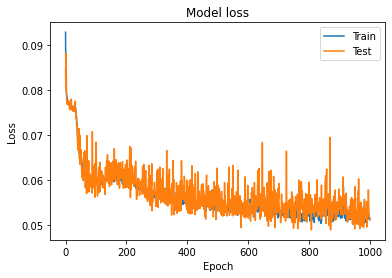

In [ ]:
# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# model.summary()
# config = model.get_config()
# model.get_weights()
# print('config',config)
# print(ascii(model))
